#  **1**  **LIBRARIES**

In [0]:
#importing all necessary libraries
import h5py
import numpy as np
import pandas as pd
from time import time

# For image / graph visualisation
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sn

# **2 IMPORTING DATA AND PRE-PROCESSING**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Please enter the desired root path, (i.e. the location of dataset on your Google Drive)
root_path = '/content/gdrive/My Drive/Colab Notebooks/Deep_Learning/Assignment/Dataset/'

In [0]:
#Data is assumed to be uploaded on the drive, from where Google Colab's working directory will use
# root_path= given path of the dataset""
with h5py.File(root_path +'train_128.h5','r') as H:
    raw_data = np.copy(H['data'])
with h5py.File(root_path +'train_label.h5','r') as H:
    raw_label = np.copy(H['label'])
with h5py.File(root_path +'test_128.h5','r') as H:
    raw_test_data = np.copy(H['data'])


## 2.1 ONE HOT ENCODING

In [0]:
# Function to encode the labels in one hot format
def onehot_encoding(list_input):
    r = len(list_input)
    c = len(np.unique(list_input))
    matrix_output = np.zeros((r,c))
    for i in range(r):
        j = list_input[i]
        matrix_output[i,j] = 1
    return matrix_output

# Create the onehot representation of the labels
onehot_raw_label = onehot_encoding(raw_label)

#print raw labels
print('Shape of the label is:',raw_label.shape)
print('\nFirst 10 raw labels:', raw_label[0:10])

#print the new format of labels
print('\nVerifying the shape of the labels after encoding:',onehot_raw_label.shape)
print('\nAbove mentioned raw labels in onehot format(first 10):\n', onehot_raw_label[0:10])

Shape of the label is: (60000,)

First 10 raw labels: [9 0 0 3 0 2 7 2 5 5]

Verifying the shape of the labels after encoding: (60000, 10)

Above mentioned raw labels in onehot format(first 10):
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


## 2.2 Standardizing raw data

In [0]:
#Standardizing the raw data
X = raw_data
input_mean = np.mean(X, axis=0).reshape(1,X.shape[1])
input_variance = np.var(X, axis=0).reshape(1,X.shape[1])
Scaled_X = (X - input_mean) / np.sqrt(input_variance)
Scaled_data = Scaled_X

# Analyzing the scaled data and it's shape
print('Shape of the scaled data remains same as raw data:',Scaled_data.shape)
print('\nScaled input data (First 5 rows and 5 columns) visualised:\n\n', Scaled_data[0:5,0:5])

Shape of the scaled data remains same as raw data: (60000, 128)

Scaled input data (First 5 rows and 5 columns) visualised:

 [[-1.10929677e-01  1.84070659e+00 -2.33960186e+00  5.32005876e-01
   6.27122889e-05]
 [ 1.24073412e+00 -5.07704675e-01 -5.02110785e-01  7.88122901e-01
   5.20609874e-01]
 [-6.38643347e-01 -1.24229380e+00  2.07715710e-01  4.45969493e-01
  -2.55667807e-01]
 [ 2.83367344e-02 -1.10513234e+00  3.95837890e-01  8.03035645e-01
   4.02503524e-02]
 [ 7.09347078e-01 -1.35315583e+00 -1.44527427e+00 -5.63753347e-01
   9.82525826e-01]]


# **3 NEURAL NETWORK**

In [0]:
#Function for visualizing the run time
def time_secs(value):
    if value < 60:
        tsec = str(np.round(value,1)) + ' seconds'
    else:
        tsec = str(int(value // 60))+' minutes, ' + str(np.round(np.mod(value,60),1)) + ' seconds'
    return tsec

## 3.1 Class for Activation Functions and their derivatives

In [0]:
class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
    
    def __softmax(self, x):
        x_max = np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x - x_max)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    # Relu and leaky relu code --
    def __relu(self, x):
        return  x * (x > 0)

    def __relu_deriv(self, a):
        # a = relu(x)
        a_grad = 1. * (a > 0)
        return a_grad
    
    def __leaky_relu(self, x):
        return x * (x >= 0) + 0.1 * x * (x < 0)

    def __leaky_relu_deriv(self, a):
        # a = leaky_relu(x)
        return 1. * (a >= 0) - 0.1 * (a < 0)
    
    # def __softmax_deriv(self, a):
        # Derivative not required to be separate, incorporated into cross-entropy
        # return a_grad
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'leaky_relu':
            self.f = self.__leaky_relu
            self.f_deriv = self.__leaky_relu_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            # self.f_deriv = self.__softmax_deriv

## 3.2 Class for Hidden Layer 

In [0]:
class HiddenLayer(object):    
    def __init__(self, n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', W=None, b=None):
    
        self.input=None
        self.activation=Activation(activation).f
        self.act_name=activation # name of the activation to prevent dropout on last layer
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )

        if activation == 'logistic':
            self.W *= 4

        self.b = np.zeros(n_out,)
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        # Adding the momentum terms
        self.W_v = np.zeros(self.W.shape)
        self.b_v = np.zeros(self.b.shape)
        
        # Adding the batchnorm terms
        self.gamma = np.ones((1, int(np.prod(n_out))))
        self.beta = np.zeros((1, int(np.prod(n_out))))      
     
     #Defining the forward propagation function   
    def forward(self, input, percent_dropout = 0, batch_norm  = True):
        
        lin_output = np.dot(input, self.W) + self.b
        
        # Confirming the layer is not the outermost layer
        if (self.act_name != 'softmax'):
            
            # Forward Batch Normalization:
            if batch_norm  == True: 
                mean_of_batch = np.mean(lin_output)
                variance_of_batch = np.var(lin_output)
                self.batch_standard_deviation = np.sqrt(variance_of_batch + 1e-8) # added number for numerical stability
                self.lin_output_hat = (lin_output - mean_of_batch) / self.batch_standard_deviation
                lin_output = self.gamma * self.lin_output_hat + self.beta
            
            # Correcting the Dropouts in Forward propagation
            if percent_dropout > 0:
                self.masks = np.random.binomial(1, (1 - percent_dropout), size=lin_output.shape) 
                lin_output = lin_output * self.masks / (1 - percent_dropout)
                  
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output
    
    #Defining the forward propagation function
    def backward(self, delta, percent_dropout = 0, batch_norm  = True, lambada = 0.1, output_layer=False):

        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta)) - lambada/self.input.shape[0]*self.W
        self.grad_b = delta
        
        # Confirming the layer is not the outermost layer
        if (self.act_name != 'softmax'):
            
            # Correcting the Dropouts in Backward propagation
            if percent_dropout > 0:
                delta = self.masks * delta / (1 - percent_dropout)
            
            #L2 Regularization term being added
            if lambada > 0:
                self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta)) - lambada/self.input.shape[0]*self.W
                
            # Backward Batch Normalization:
            if batch_norm  == True:
                delta_n = delta.shape[0]
                beta_d = np.sum(delta, axis=0)
                gamma_d = np.sum(self.lin_output_hat * delta, axis=0)
                delta = (self.gamma * (1 / self.batch_standard_deviation) / delta_n) * (delta_n * delta - self.lin_output_hat * gamma_d - beta_d)
            
        if self.activation_deriv:    
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
           
        return delta

## 3.3 Class for The MLP 

In [0]:
class MLP:
       
    def __init__(self, layers, activation=[None,'tanh','tanh']):
        
        ### initialize the layers
        self.layers=[]
        self.params=[]
        
        print('Layers:', layers)
        print('Activations:', activation,'\n')
        
        self.activation=activation
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1]))
    
    #Forward propagation
    def forward(self, input, percent_dropout = 0, batch_norm =True):
        for layer in self.layers:
            output=layer.forward(input, percent_dropout, batch_norm )
            input=output
        return output
    
    #Cross entropy criterion (The one we are using)
    def crossentropy_criterion(self, y_actual, y_hat, lambada = 0.1):
        no_of_samples = y_actual.shape[0]
        delta = (y_hat - y_actual) / no_of_samples
        loss = np.sum(- np.log(y_hat[np.arange(no_of_samples), y_actual.argmax(axis=1)]))/ no_of_samples
        
        # Function to compute the L2 Regularization cost
        if lambada > 0:
            for layer in self.layers:
                L2_Regularization_loss = (np.sum(np.square(layer.W)))*(lambada/(2*no_of_samples))
                loss = loss + L2_Regularization_loss
        
        return loss, delta
    
    #Backwards propagation of the information
    def backward(self,delta, percent_dropout = 0, batch_norm =True, lambada = 0.1):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta, percent_dropout, batch_norm, lambada)
     
    #Updating the parameters:
    def update_parameters(self, lrate, momentum_of_gamma = 0.5):
        for layer in self.layers:
            # Momentum adjustments
            layer.W_v = momentum_of_gamma * layer.W_v + lrate * layer.grad_W
            layer.b_v = momentum_of_gamma * layer.b_v + lrate * np.mean(layer.grad_b, axis = 0)
            layer.b -= layer.b_v
            layer.W -= layer.W_v          
            
            
    #Fitting the model with the training function with relevant regularization methods
    def fit(self,X,y,learning_rate=0.1, epochs=100, mini_batch_size = 1, 
            loss_function = 'cross-entropy', percent_dropout = 0, interval_reported = 50,
            momentum_of_gamma = 0.5, batch_norm  = True, lambada = .1, convergence_threshold = 0.1):
        
        X=np.array(X)
        y=np.array(y)
        ret = np.zeros(epochs)
        
        no_of_samples = X.shape[0]
        no_of_classes = y.shape[1]
        print('Total planned number of epochs:', epochs)
        print('Convergence threshold (min change in loss per report interval):', str(convergence_threshold)+'%')
        print('Total number of classes:',no_of_classes)
        print('Total number of training samples:',no_of_samples)
        print('Each batch size:', mini_batch_size)
        no_of_batches = no_of_samples // mini_batch_size
        print('Total number of batches:', no_of_batches,'\n')
        early_loss=0
        converge = False
        epoch_start_time = time()
        
        #Looping though the epochs:
        for p in range(epochs):        
            loss = np.zeros(no_of_batches)
            delta = np.zeros((no_of_batches, no_of_classes))
            
            #Looping through the mini batches:
            for k in range(no_of_batches):                
                ix0 = k * mini_batch_size
                ix1 = (k+1) * mini_batch_size
                mini_batch = X[ix0:ix1]
                
                #forwards propagation
                y_hat = self.forward(mini_batch, percent_dropout, batch_norm)
                y_actual = y[ix0:ix1]
                
                #The loss output
                loss[k], delta = self.crossentropy_criterion(y_actual, y_hat, lambada)
                
                #Back propogation
                self.backward(delta, percent_dropout, batch_norm, lambada)
                self.update_parameters(lrate, momentum_of_gamma)
            
            #Take the mean of all the mini batches
            mean_loss = np.mean(loss)
            
            #Checking the convergence of the model
            if p % interval_reported == 0:
                epoch_elapsed_time = (time() - epoch_start_time)
                epoch_start_time = time() # reset
                print('Epoch: '+ str(p) + ",   Time: " + time_secs(epoch_elapsed_time) +",   Loss: ", 
                      np.round(mean_loss,8))
                if early_loss > 0:
                    change_in_loss = (early_loss - mean_loss) / early_loss
                    if change_in_loss < (convergence_threshold / 100):
                        converge = True
                early_loss = mean_loss
                    
            ret[p] = mean_loss
            if converge:
                print('\nConvergence criteria achieved. Training completed (at epoch '+str(p)+').')
                return ret[0:p]
        print('\nMaximum no of planned epochs achieved. Training completed (at epoch '+str(p)+').')
        return ret
    
    def predict(self, x, no_of_classes):
       
        x = np.array(x)
        output = np.zeros((x.shape[0], no_of_classes))
        for i in np.arange(x.shape[0]):
            output[i] = nn.forward(np.atleast_2d(x[i,:]))
        return output

## 3.4 Initialising Hyperparameters for further tuning

In [0]:
# Define the architecture of NN

primary_activation = 'relu'         # 'leaky_relu', 'relu', 'logistic' or 'tanh'
HL_neurons = [1024, 64]

# Define various hyperparameters
#All these are further tuned for getting the best result

lrate = 0.04                   # learning rate
size_of_batch = 500            # batch size of the mini batches
percent_dropout = 0.25         # percentage of neurons to turn off (all layers except last); 
                                 # set to zero to disable this feature
momentum_of_gamma = 0.7        # parameter for momentum of gamma
batch_norm  = False            # Batch normalisation toggle value
lambada = 0.003                # Weight decay parameter used for L2 regularisation

# Defined stopping and reporting conditions

planned_epochs = 1000             # maximum planned no of epochs
interval_reported = 10            # frequency of reporting time (including loss percentage every time)
convergence_threshold = 0.1       # convergence threshold (for percent change of loss per reporting interval)

## 3.5 Initialising NN

In [0]:
# Determine neural network architecture
no_of_features = raw_data.shape[1]
no_of_classes = onehot_raw_label.shape[1]

# Assign neurons and activations
final_layer_activation = 'softmax'          
def_loss_function = 'cross-entropy'   # loss function to be fed into optimiser ('cross-entropy' or 'MSE')

each_layer_neuron = np.append(np.append(no_of_features,HL_neurons),no_of_classes)

each_layer_activation = [None]
for i in range(1,len(each_layer_neuron)-1):
    each_layer_activation = np.append(each_layer_activation, primary_activation)
each_layer_activation = np.append(each_layer_activation, final_layer_activation)

# Initialising the neural network
nn = MLP(each_layer_neuron, each_layer_activation)
print('Neural network is initialised.')


Layers: [ 128 1024   64   10]
Activations: [None 'relu' 'relu' 'softmax'] 

Neural network is initialised.


## 3.6 Class for Predicting Accuracy

In [0]:
# Determining accuracy (ZP Code)
def model_accuracy (y_actual, y_pred):
    s = y_actual.shape[0]
    print('Count:', s)
    m = np.sum(y_pred == y_actual)
    print('Matches:', m)
    acc = m / s
    return acc

def class_output (y_hat):
    y_pred = np.argmax(y_hat, axis=1)
    return y_pred

# 4 TRAINING THE MODEL

## 4.1 Split the dataset

In [0]:
#splitting the given dataset into test and training to determine accuracy
def train_test_split(m_train, Scaled_data,onehot_raw_label): 
  train_n= int(m_train*Scaled_data.shape[0])
  return Scaled_data[:train_n], Scaled_data[train_n:], onehot_raw_label[:train_n],onehot_raw_label[train_n:]

m_train = 0.8 #80-20 split of training and test data 
train_scaled_data, test_scaled_data, selected_train_label, selected_test_label = train_test_split(m_train,Scaled_data,onehot_raw_label)

## 4.2 Fit the Model

In [0]:
starting_time = time()

# Initialise the neural network
nn = MLP(each_layer_neuron, each_layer_activation)
print('Neural network is initialised.')

np.random.seed(10)
starting_time = time()

# Train the neural network
nn_loss_optimised = nn.fit(train_scaled_data, selected_train_label, learning_rate=lrate, 
                      epochs=planned_epochs, mini_batch_size = size_of_batch, loss_function = def_loss_function,
                      percent_dropout=percent_dropout, interval_reported=interval_reported, batch_norm =batch_norm,
                      lambada=lambada, convergence_threshold=convergence_threshold)
    
elapsed_time = time() - starting_time
print("\nTraining time taken is:", time_secs(elapsed_time))
    
print('\nLoss:%f'%nn_loss_optimised[-1])

Layers: [ 128 1024   64   10]
Activations: [None 'relu' 'relu' 'softmax'] 

Neural network is initialised.
Total planned number of epochs: 1000
Convergence threshold (min change in loss per report interval): 0.1%
Total number of classes: 10
Total number of training samples: 48000
Each batch size: 500
Total number of batches: 96 

Epoch: 0,   Time: 6.6 seconds,   Loss:  1.46994624
Epoch: 10,   Time: 1 minutes, 4.9 seconds,   Loss:  0.35898048
Epoch: 20,   Time: 1 minutes, 5.1 seconds,   Loss:  0.28730881
Epoch: 30,   Time: 1 minutes, 4.9 seconds,   Loss:  0.24280275
Epoch: 40,   Time: 1 minutes, 4.9 seconds,   Loss:  0.21250273
Epoch: 50,   Time: 1 minutes, 5.4 seconds,   Loss:  0.18499833
Epoch: 60,   Time: 1 minutes, 4.8 seconds,   Loss:  0.16966655
Epoch: 70,   Time: 1 minutes, 5.5 seconds,   Loss:  0.15079539
Epoch: 80,   Time: 1 minutes, 5.2 seconds,   Loss:  0.13489926
Epoch: 90,   Time: 1 minutes, 5.4 seconds,   Loss:  0.12364697
Epoch: 100,   Time: 1 minutes, 5.8 seconds,   Loss

## 4.3 Visualize epoch-wise loss

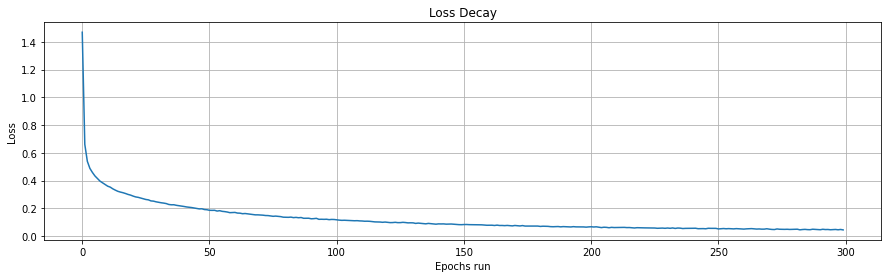

In [0]:
#Visualizing epoch wise loss

plt.figure(figsize=(15,4))
plt.title('Loss Decay')
plt.xlabel('Epochs run')
plt.ylabel('Loss')
plt.plot(nn_loss_optimised)
plt.grid()

# 5 PREDICTIONS AND ACCURACY

In [0]:
# Function to build confusion matrix

def build_confusion_matrix(y_actual, y_pred):
    n_i = len(np.unique(y_actual))
    n_j = len(np.unique(y_pred))
    print(n_i, n_j)
    cm = np.zeros((n_i, n_j))
    for it in range(len(y_actual)):
        i = y_actual[it]
        j = y_pred[it]
        cm[i,j] += 1
    return cm

## 5.1 Prediction of train splitted data

In [0]:
#Calculating the accuracy of the 80% of raw data, on which model was trained
Y_hat_test = nn.predict(train_scaled_data, no_of_classes)
y_predic_train = class_output(Y_hat_test)
print('Accuracy of trained dataset: ',model_accuracy(y_predic_train,class_output(selected_train_label))*100)

Count: 48000
Matches: 47786
Accuracy of trained dataset:  99.55416666666666


10 10


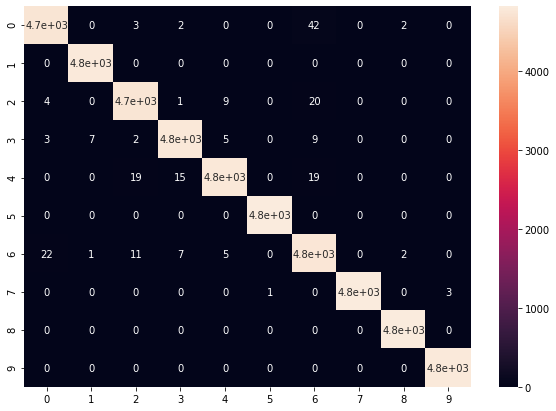

In [0]:
# Plot the confusion matrix of trained data

cm = build_confusion_matrix(y_predic_train,class_output(selected_train_label))
df_cm = pd.DataFrame(cm, index = [i for i in range(10)],
                  columns = [i for i in range(10)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

## 5.2 Prediction of test splitted data

In [0]:
#Calculating the accuracy of the 20% of raw data, on which model was to be tested

Y_hat_test = nn.predict(test_scaled_data, no_of_classes)
y_predic_test = class_output(Y_hat_test)
print('Accuracy of split tested dataset: ',model_accuracy(y_predic_test,class_output(selected_test_label))*100)

Count: 12000
Matches: 10825
Accuracy of split tested dataset:  90.20833333333333


10 10


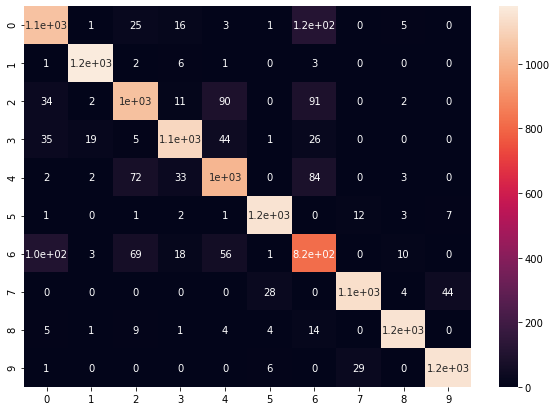

In [0]:
# Plot the confusion matrix of trained data

cm = build_confusion_matrix(y_predic_test,class_output(selected_test_label))
df_cm = pd.DataFrame(cm, index = [i for i in range(10)],
                  columns = [i for i in range(10)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

## 5.3 Predicting output labels

In [0]:
Y_hat_test = nn.predict(raw_test_data, no_of_classes)
y_predic_test_labels = class_output(Y_hat_test)
print('Predicted labels:', y_predic_test_labels.shape, '\n', y_predic_test_labels)

Predicted labels: (10000,) 
 [9 2 1 ... 8 1 7]


# 6 EXPORTING OUTPUT LABELS TO FILE

In [0]:
export_file = h5py.File(root_path +'Predicted_labels.h5', 'w')
export_file.create_dataset('label', data=y_predic_test_labels)
export_file.close()